In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import torch
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd

from src.data.gamma.structural_arxiv import load_dataset, get_train_val_test_edges, prepare_adjencency, get_edge_index_from_adjencency
from src.train.structural_omega.gat import StructuralOmegaGATCosSim

/home/caiolmartinelli/.cache/pypoetry/virtualenvs/arxiv-paperclassification-f16XUvnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset_name = 'ogbn-arxiv'
logs_filename = 'logs/omega_function/06-1-structural_gat_cossim_gamma_function.log'

In [4]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename=logs_filename
)

In [5]:
torch.cuda.is_available()

True

In [6]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [7]:
dataset = load_dataset()

In [8]:
data, edges_train, edges_val, edges_test = get_train_val_test_edges(dataset, device='cpu')

In [9]:
data = prepare_adjencency(data)

## Training

In [ ]:
for run in range(5):
    for n_layers_gat in range(1, 4):
        omega = StructuralOmegaGATCosSim(
            'cpu',
            n_layers_gat=n_layers_gat,
            run=run)
        torch.cuda.empty_cache()
        omega.train(edges_train,
                    edges_val,
                    edges_test,
                    data.x,
                    data.y,
                    data.adj_t)

## Results

### For a Layer Number

In [7]:
n_layers_gat = 1

In [8]:
metrics = StructuralOmegaGATCosSim.read_metrics(
    dataset=dataset_name,
    n_layers_gat=n_layers_gat)
print(metrics.shape)
metrics.head()

(245, 8)


,run,epoch,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
0,0,0,0.628807,0.665304,0.671128,0.607031,0.608758,0.608805
1,0,25,0.588830,0.605784,0.612778,0.725094,0.737146,0.723751
2,0,50,0.571706,0.588898,0.598432,0.743302,0.747079,0.731008
3,0,75,0.561102,0.578717,0.590596,0.751820,0.752542,0.734513
4,0,100,0.554041,0.571691,0.585152,0.756209,0.755077,0.736679


### Sumarize metrics per epoch

In [9]:
metrics_cols = metrics.columns[2:]
metrics_cols

Index(['loss_train', 'loss_val', 'loss_test', 'auc_train', 'auc_val',
       'auc_test'],
      dtype='object')

In [10]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [11]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
0,0.628740,0.000105,0.665190,0.000132,0.671021,0.000134,0.608692,0.003353,0.610631,0.005067,0.609503,0.004631
25,0.588270,0.000746,0.605573,0.001279,0.613023,0.001851,0.724182,0.003422,0.734934,0.006533,0.720549,0.007713
50,0.572316,0.000984,0.590314,0.002449,0.599668,0.002051,0.741938,0.001350,0.745787,0.004087,0.730286,0.002714
75,0.562174,0.001244,0.579871,0.001676,0.591679,0.001011,0.751419,0.001645,0.752136,0.003817,0.733666,0.001910
100,0.554707,0.001397,0.572355,0.001527,0.585847,0.000682,0.757386,0.001155,0.756614,0.001377,0.736889,0.000817


In [12]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
1975,0.495295,0.000474,0.529960,0.000527,0.555746,0.000283,0.800183,0.000193,0.790880,0.000794,0.768613,0.000518
1850,0.495775,0.000342,0.529571,0.000234,0.554947,0.001598,0.799795,0.000545,0.790731,0.000542,0.768705,0.000308
1775,0.495725,0.000485,0.529551,0.000658,0.554937,0.000832,0.799700,0.000288,0.790719,0.000878,0.768669,0.000397
1875,0.495483,0.000388,0.529560,0.000725,0.554694,0.002076,0.799768,0.000424,0.790666,0.001114,0.768962,0.000837
1825,0.496042,0.000427,0.530258,0.000416,0.556074,0.000692,0.799621,0.000365,0.790656,0.000640,0.768463,0.000457


/tmp/ipykernel_39410/2295558650.py:8: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_39410/2295558650.py:9: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_39410/2295558650.py:56: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavio

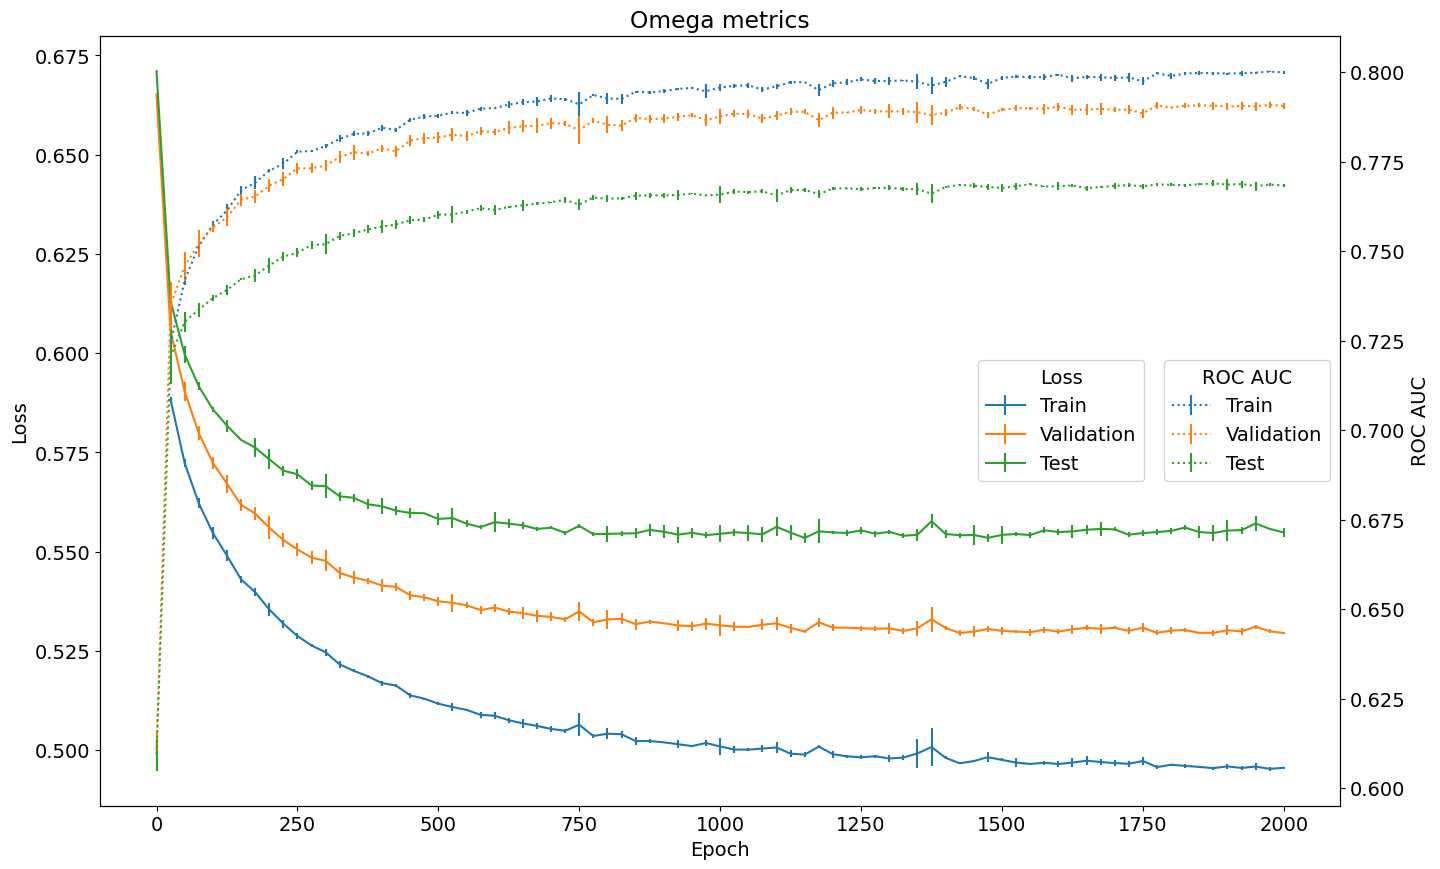

In [13]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Omega metrics')

ax1.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['loss_train_mean'][1:],
    yerr=epoch_metrics['loss_train_std'][1:],
    ls='-',
    label='Train')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_val_mean'],
    yerr=epoch_metrics['loss_val_std'],
    ls='-',
    label='Validation')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_test_mean'],
    yerr=epoch_metrics['loss_test_std'],
    ls='-',
    label='Test')

# ax1.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['loss_train_mean'][1:],
#     # yerr=epoch_metrics['loss_train_std'][1:],
#     ls='-',
#     label='Train')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_val_mean'],
#     # yerr=epoch_metrics['loss_val_std'],
#     ls='-',
#     label='Validation')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_test_mean'],
#     # yerr=epoch_metrics['loss_test_std'],
#     ls='-',
#     label='Test')

ax1.legend(loc='center right', title='Loss', bbox_to_anchor=[0.85, 0.5])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()

ax2.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['auc_train_mean'][1:],
    yerr=epoch_metrics['auc_train_std'][1:],
    ls=':',
    label='Train')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_val_mean'],
    yerr=epoch_metrics['auc_val_std'],
    ls=':',
    label='Validation')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_test_mean'],
    yerr=epoch_metrics['auc_test_std'],
    ls=':',
    label='Test')

# ax2.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['auc_train_mean'][1:],
#     # yerr=epoch_metrics['auc_train_std'][1:],
#     ls=':',
#     label='Train')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_val_mean'],
#     # yerr=epoch_metrics['auc_val_std'],
#     ls=':',
#     label='Validation')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_test_mean'],
#     # yerr=epoch_metrics['auc_test_std'],
#     ls=':',
#     label='Test')

ax2.legend(loc='center right', title='ROC AUC', bbox_to_anchor=[1, 0.5])
ax2.set_ylabel('ROC AUC')

plt.savefig(f'reports/images/structural_omega_gat_cossim_training_metrics_{n_layers_gat}gslayers.pdf')

### Comparing Validation Performance for All Layer numbers

In [14]:
n_layers_list = range(1, 3)

In [15]:
mean_auc_val_dict = {}
mean_loss_val_dict = {}
std_auc_val_dict = {}
std_loss_val_dict = {}
for n_layers_gat in n_layers_list:
    metrics = StructuralOmegaGATCosSim.read_metrics(
        dataset=dataset_name,
        n_layers_gat=n_layers_gat)
    mean_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    
    auc_val = mean_df['auc_val']
    loss_val = mean_df['loss_val']
    mean_auc_val_dict[n_layers_gat] = auc_val
    mean_loss_val_dict[n_layers_gat] = loss_val

    std_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].std()

    auc_val = std_df['auc_val']
    loss_val = std_df['loss_val']
    std_auc_val_dict[n_layers_gat] = auc_val
    std_loss_val_dict[n_layers_gat] = loss_val

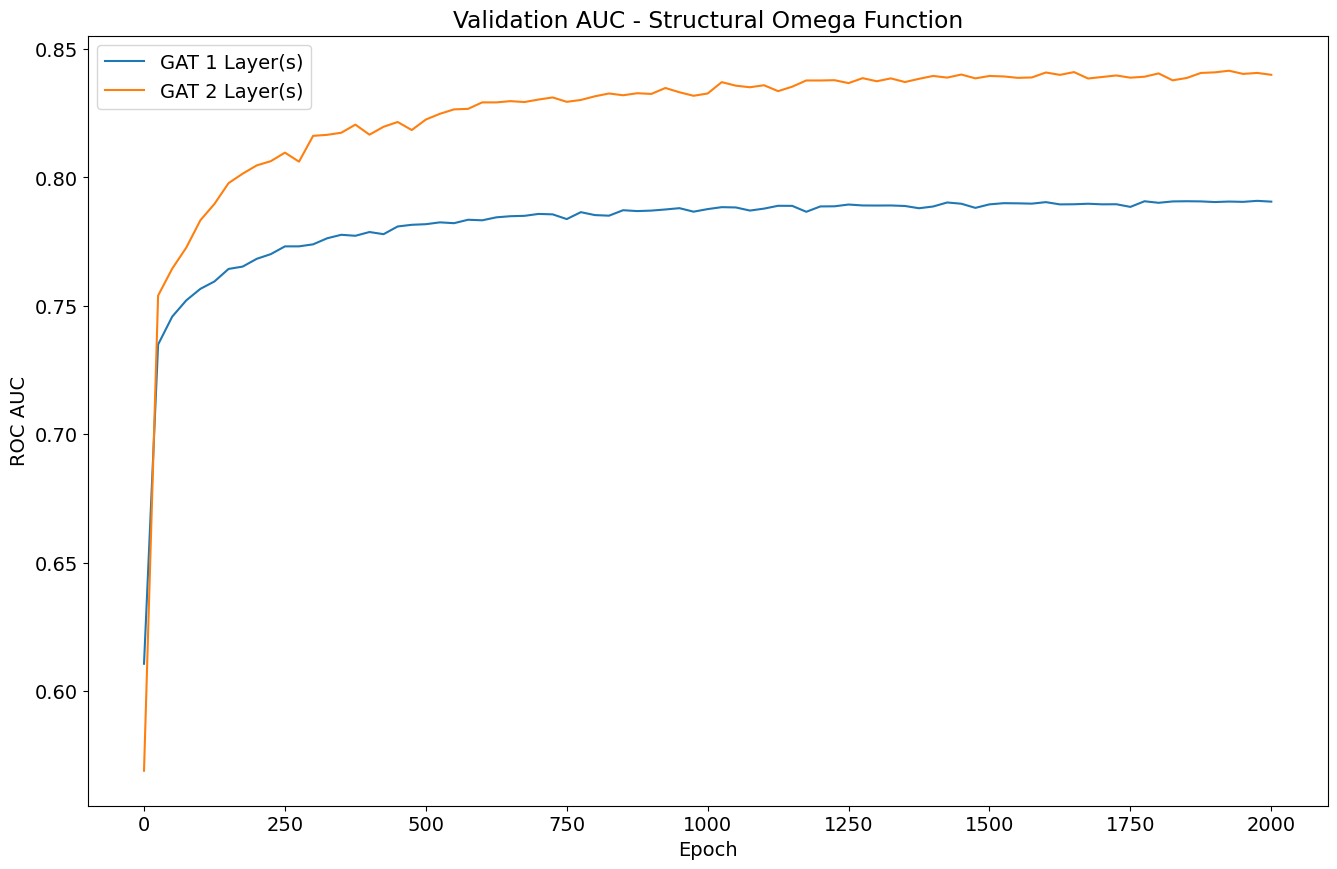

In [16]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Validation AUC - Structural Omega Function')

for n_layers in mean_auc_val_dict:
    # ax1.errorbar(
    #     mean_auc_val_dict[n_layers].index,
    #     mean_auc_val_dict[n_layers],
    #     yerr=std_auc_val_dict[n_layers],
    #     ls='-',
    #     label=f'GAT {n_layers} Layer(s)')

    ax1.plot(
        mean_auc_val_dict[n_layers].index,
        mean_auc_val_dict[n_layers],
        # yerr=std_auc_val_dict[n_layers],
        ls='-',
        label=f'GAT {n_layers} Layer(s)')

# ax1.set_xlim(-50, 5000)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('ROC AUC')

ax1.legend()

## Score Best model

In [17]:
best_model_metrics = metrics.sort_values('auc_val', ascending=False).iloc[0]
best_model_metrics

run              2.000000
epoch         1950.000000
loss_train       0.423870
loss_val         0.479965
loss_test        0.522681
auc_train        0.867619
auc_val          0.843228
auc_test         0.812247
Name: 240, dtype: float64

In [18]:
best_model_metrics.to_json(f'models/structural_omega_gat_cossim/{dataset_name}/best_model_info.json')

### Load data

In [19]:
dataset = load_dataset()

data, edges_train, edges_val, edges_test = get_train_val_test_edges(
    dataset=dataset, device=device
)

data = prepare_adjencency(data, to_symmetric=True)

edge_index = get_edge_index_from_adjencency(data, device)

### Load model

In [20]:
data.num_nodes

169343

In [21]:
omega = StructuralOmegaGATCosSim.load_model(
    dataset=dataset_name,
    run=int(best_model_metrics['run']),
    epoch=int(best_model_metrics['epoch']),
    device=device,
    n_layers_gat=2,
    batch_size=1)

In [22]:
dataset

PygNodePropPredDataset()

### Score model

In [23]:
dataset = load_dataset()
data = prepare_adjencency(dataset[0], to_symmetric=True).to(device)

edge_index = get_edge_index_from_adjencency(data, device)

In [24]:
edge_index

tensor([[   411,    640,   1162,  ..., 163274,  27824, 158981],
        [     0,      0,      0,  ..., 169341, 169342, 169342]],
       device='cuda:0')

In [25]:
edges_train

tensor([[104447,  15858, 107156,  ...,   1326, 129609,  26457],
        [ 13091,  47283,  69161,  ...,  55379, 158430,  54167]],
       device='cuda:0')

In [26]:
preds_train = omega.forward(edges_train, data.x, data.adj_t).to('cpu').detach().numpy()
preds_train[:5]

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.19 GiB (GPU 0; 5.80 GiB total capacity; 2.92 GiB already allocated; 938.31 MiB free; 4.05 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
preds_val = omega.forward(edges_val, data.x, data.adj_t).to('cpu').detach().numpy()
preds_val[:5]

array([[0.8617763 ],
       [0.90067077],
       [0.69407076],
       [0.08553965],
       [0.84357154]], dtype=float32)

In [ ]:
preds_test = omega.forward(edges_test, data.x, data.adj_t).to('cpu').detach().numpy()
preds_test[:5]

array([[0.90101534],
       [0.9159397 ],
       [0.909675  ],
       [0.69181824],
       [0.89208484]], dtype=float32)

In [ ]:
preds = np.concatenate([preds_train, preds_val, preds_test])

In [ ]:
edges = torch.concat([edges_train, edges_val, edges_test], dim=1)
edges

tensor([[104447,  15858, 107156,  ...,  45118,  45118,  45118],
        [ 13091,  47283,  69161,  ..., 162473, 162537,  72717]],
       device='cuda:0')

In [ ]:
theta = omega.is_same_class(edges, data.y).to('cpu').detach().numpy()

In [ ]:
roc_auc_score(theta, preds)

0.8475192161947509

In [ ]:
theta.mean()

0.655083031580897

### Save output

In [ ]:
cpu_edges = edges.to('cpu').numpy()
edges_omega_df = pd.DataFrame({
    'source': cpu_edges[0],
    'target': cpu_edges[1],
    'omega_pred': preds[:,0]
})
print(edges_omega_df.shape)
edges_omega_df.head()

(1166243, 3)


,source,target,omega_pred
0,104447,13091,0.867907
1,15858,47283,0.496444
2,107156,69161,0.075095
3,107156,136440,0.484338
4,107156,107366,0.355051


In [ ]:
edges_omega_df.to_csv(f'data/scored_omega/{dataset_name}/structural_omega_gat_cossim.csv', index=False)

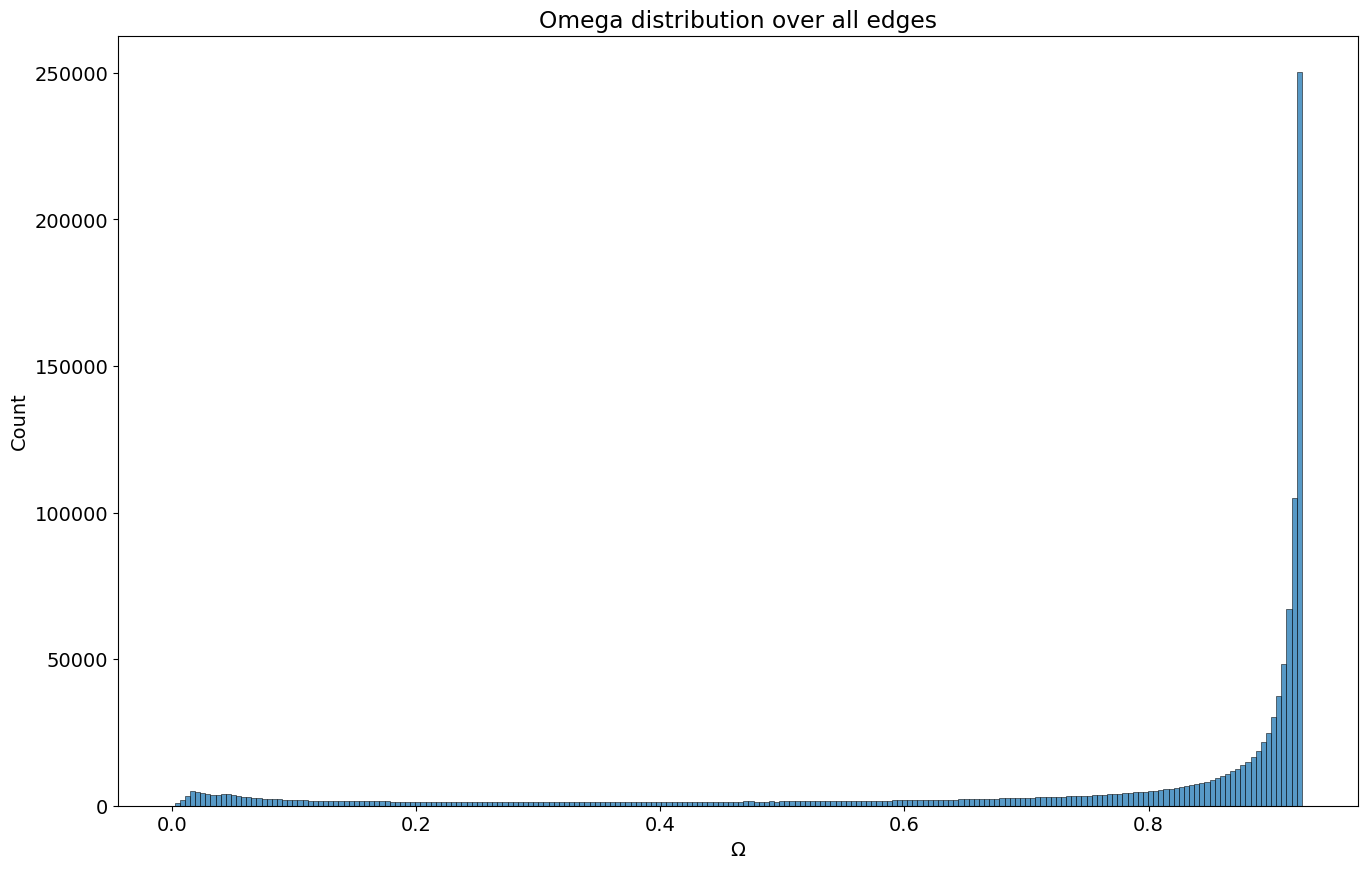

In [ ]:
plt.rcParams['font.size'] = '14'
plt.figure(figsize=(16, 10))

sns.histplot(
    edges_omega_df['omega_pred'])

plt.xlabel('$\Omega$')
plt.title('Omega distribution over all edges')
plt.savefig(f'reports/images/{dataset_name}/structural_omega_gat_cossim/best_omega_distribution.png')

In [ ]:
metrics = {
    'ROC AUC - All edges': [roc_auc_score(theta, preds)],
    'Mean': [edges_omega_df['omega_pred'].mean()],
    'Std. Dev.': [edges_omega_df['omega_pred'].std()],
    'Skewness': [edges_omega_df['omega_pred'].skew()],
    'Kurtosis': [edges_omega_df['omega_pred'].kurt()],
}

print(pd.DataFrame(metrics).round(3).style.to_latex())

\begin{tabular}{lrrrrr}
 & ROC AUC - All edges & Mean & Std. Dev. & Skewness & Kurtosis \\
0 & 0.848000 & 0.748000 & 0.270000 & -1.588000 & 1.139000 \\
\end{tabular}

